### 

In [1]:
# make env
# pip install requests
# %pip install pandas
# %pip install matplotlib 
# %pip install -U scikit-learn

In [2]:
# Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, HTML
import math

### Load Dataset

In [3]:
# Dataset Source: https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset?select=cbb13.csv

dataframes = {}
directory = 'march_mad_data'

# Load general cbb.csv dataset into a dataframe
for filename in os.listdir(directory):
    if filename.endswith("cbb.csv"):
        path = os.path.join(directory, filename)
        dataframes[filename] = pd.read_csv(path)

In [4]:
df = dataframes["cbb.csv"]
print(df)

                TEAM  CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D   TOR  \
0     North Carolina   ACC  40  33  123.3   94.9   0.9531   52.6   48.1  15.4   
1          Wisconsin   B10  40  36  129.1   93.6   0.9758   54.8   47.7  12.4   
2           Michigan   B10  40  33  114.4   90.4   0.9375   53.9   47.7  14.0   
3         Texas Tech   B12  38  31  115.2   85.2   0.9696   53.5   43.0  17.7   
4            Gonzaga   WCC  39  37  117.8   86.3   0.9728   56.6   41.1  16.2   
...              ...   ...  ..  ..    ...    ...      ...    ...    ...   ...   
3518          Toledo   MAC  34  27  119.9  109.6   0.7369   56.3   52.9  13.6   
3519         Liberty  ASun  33  27  111.4   97.3   0.8246   55.5   49.3  16.0   
3520     Utah Valley   WAC  34  28  107.1   94.6   0.8065   51.7   44.0  19.3   
3521             UAB  CUSA  38  29  112.4   97.0   0.8453   50.3   47.3  17.3   
3522     North Texas  CUSA  36  31  110.0   93.8   0.8622   51.2   44.5  19.8   

      ...  FTRD  2P_O  2P_D

### Data Cleaning

In [5]:
clean_df = df.replace("N/A", "NA")
print(df["SEED"].unique())
print(f"number of rows: {len(clean_df)}")
print(f"number of columns: {len(clean_df.columns)}")

[ 1.  3.  8.  4.  2.  7.  6.  9. 11. 10.  5. nan 16. 12. 13. 14. 15.]
number of rows: 3523
number of columns: 24


In [6]:
# Convert seed data into whether or not a team qualifies (nan vs a seed number)
print(clean_df[clean_df["SEED"] < 1])
clean_df["QUALIFY"] = clean_df["SEED"].map(lambda x: 0 if math.isnan(x) else 1)
print(clean_df["QUALIFY"])

Empty DataFrame
Columns: [TEAM, CONF, G, W, ADJOE, ADJDE, BARTHAG, EFG_O, EFG_D, TOR, TORD, ORB, DRB, FTR, FTRD, 2P_O, 2P_D, 3P_O, 3P_D, ADJ_T, WAB, POSTSEASON, SEED, YEAR]
Index: []

[0 rows x 24 columns]
0       1
1       1
2       1
3       1
4       1
       ..
3518    0
3519    0
3520    0
3521    0
3522    0
Name: QUALIFY, Length: 3523, dtype: int64


In [7]:
# Check number datapoints that qualify for the tournament and don't qualify for the tournament
print("Number of team datapoints: ", len(clean_df["QUALIFY"]))
print("Number of unqualified teams: ", len(clean_df[clean_df["QUALIFY"] == 0])) # Not qualified
print("Number of qualified teams: ", len(clean_df[clean_df["QUALIFY"] == 1])) # Qualified

Number of team datapoints:  3523
Number of unqualified teams:  2843
Number of qualified teams:  680


680 2843


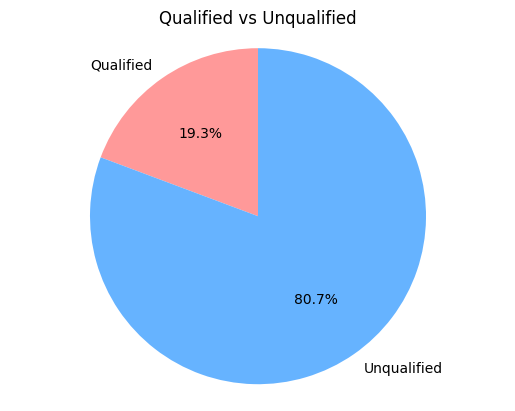

In [8]:
import matplotlib.pyplot as plt

# Data
qualified_count = len(clean_df[clean_df['QUALIFY'] == 1])
unqualified_count = len(clean_df[clean_df['QUALIFY'] == 0])
print(qualified_count, unqualified_count)

# Pie chart
labels = ['Qualified', 'Unqualified']
sizes = [qualified_count, unqualified_count]
colors = ['#ff9999','#66b3ff']
# explode = (0.1, 0)  # explode the first slice

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Qualified vs Unqualified')
plt.show()

In [9]:
# Undersample data to balance number of teams that qualify and don't qualify for training
smaller_count = len(clean_df[clean_df["QUALIFY"] == 1])
class1 = clean_df[clean_df["QUALIFY"] == 0] # Class that is undersampled
class1 = class1.sample(smaller_count)
class2 = clean_df[clean_df["QUALIFY"] == 1]
clean_df = pd.concat([class1, class2],axis=0)

# Drop columns we don't want


### Exploratory Data Analysis (EDA)

In [10]:
qualify_df = clean_df
print(qualify_df["QUALIFY"].unique())
print(len(qualify_df))

[0 1]
1360


In [11]:
# Get a list of the NCAA men's basketball conferences
conferences = qualify_df['CONF'].unique()

In [12]:
qualify_df = qualify_df.drop(columns=['TEAM', 'SEED', 'POSTSEASON'])
one_hot_encoded = pd.get_dummies(qualify_df['CONF'])
qualify_df = qualify_df.drop(columns=['CONF'])
qualify_df = pd.concat([qualify_df, one_hot_encoded], axis=1)
qualify_df['WINRATE'] = qualify_df['W'] / qualify_df['G']

In [13]:
# Compare conference and whether the team qualifies for March Madness (EDA)
print(len(conferences), "conferences")
print(sum(qualify_df["QUALIFY"]), "qualifiers")

conf_counts = {}
for conf in conferences:
    conf_counts[conf] = sum(qualify_df.loc[qualify_df[conf] == 1]["QUALIFY"])

for conf_name, conf_count in sorted(conf_counts.items(), key=lambda item: -item[1]):
    print(conf_name + ": ", conf_count)

34 conferences
680 qualifiers
B10:  72
B12:  65
ACC:  65
BE:  55
SEC:  54
P12:  44
A10:  30
MWC:  26
Amer:  25
WCC:  19
MVC:  14
BSth:  11
SB:  11
OVC:  11
AE:  10
SWAC:  10
BSky:  10
NEC:  10
CUSA:  10
MAC:  10
BW:  10
Sum:  10
Horz:  10
MAAC:  10
Pat:  10
SC:  10
CAA:  10
MEAC:  10
Slnd:  10
WAC:  10
Ivy:  9
ASun:  9
GWC:  0
ind:  0


In [14]:
correlation_table = qualify_df.corr()['QUALIFY']

# Sort the correlation table
sorted_correlation_table = correlation_table.sort_values(ascending=False)

# Display the sorted correlation table with scrollable output
display(HTML(sorted_correlation_table.to_frame().to_html()))


,QUALIFY
QUALIFY,1.000000
WAB,0.729725
W,0.702548
WINRATE,0.678559
BARTHAG,0.674515
ADJOE,0.623935
EFG_O,0.436493
G,0.428575
2P_O,0.391360
3P_O,0.338966


### EDA Analysis

In [15]:
### Team attributes with the highest impact on tournament qualification 
### (larger magnitude correlations from the correlation table)

# WAB = Wins Above Bubble (May not use because bubble/March Madness cutoff is always changing)
# W = Wins
# BARTHAG = Power Ranking / Chance of beating an average D1 team (May not use because subjective power-ranking)
# WINRATE = Wins / Games Played
# ADJOE = Adjusted Offensive Efficiency (number of points scored every 100 possessions)
# EFG_O = Effective Field Goal Percentage Short
# G = Games
# 2P_O = 2 Point shooting percentage

# ADJDE = Adjusted Defensive Efficiency (number of points allowed every 100 opponent possessions)
# EFG_D = Effective Field Goal percentage allowed
# 2P_D = 2 Point shooting percentage allowed


### Training Machine Learning Models

#### Create data splits

In [16]:
# Select the relevant columns for training the model
features = ['WINRATE', 'ADJOE', 'ADJDE', 'EFG_O', 'EFG_D', '2P_O', '2P_D']

# Split the data into training and testing sets
X = qualify_df[features]
y = qualify_df['QUALIFY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#### Decision Tree

In [17]:
# Create a decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8455882352941176


#### Random Forest Classifier

In [18]:
# Train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8676470588235294


### Grid Search RF

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the random forest classifier
rf = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best parameters to create the final random forest model
final_rf = RandomForestClassifier(**best_params)

# Fit the final model to the training data
final_rf.fit(X_train, y_train)

# Evaluate the final model on the test data
accuracy = final_rf.score(X_test, y_test)

In [20]:
print("Final Random Forest Model Accuracy:", accuracy)

Final Random Forest Model Accuracy: 0.8529411764705882


#### Neural Network

In [21]:
from sklearn.neural_network import MLPClassifier

# Create an instance of the MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='relu', solver='adam', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = model.score(X_test, y_test)

# Print the predictions and accuracy
print("Predictions:", predictions)
print("Accuracy:", accuracy)

Predictions: [0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0
 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1
 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1]
Accuracy: 0.8161764705882353


In [22]:
# Print actual vs predicted qualification to check how accurate the predictions are
# model = dt_classifier # Change to whatever model you want to use
model = rf_classifier 

actual_qualifications = qualify_df.loc[X_test.index]['QUALIFY']
predicted_qualifications = model.predict(X_test)
for actual_qualification, predicted_qualification in zip(actual_qualifications, predicted_qualifications):
    print("Actual Qualification:", actual_qualification, ", Predicted Qualification:", predicted_qualification)

Actual Qualification: 0 , Predicted Qualification: 0
Actual Qualification: 1 , Predicted Qualification: 1
Actual Qualification: 1 , Predicted Qualification: 1
Actual Qualification: 0 , Predicted Qualification: 0
Actual Qualification: 1 , Predicted Qualification: 0
Actual Qualification: 0 , Predicted Qualification: 0
Actual Qualification: 1 , Predicted Qualification: 0
Actual Qualification: 1 , Predicted Qualification: 1
Actual Qualification: 1 , Predicted Qualification: 1
Actual Qualification: 1 , Predicted Qualification: 1
Actual Qualification: 0 , Predicted Qualification: 0
Actual Qualification: 0 , Predicted Qualification: 0
Actual Qualification: 1 , Predicted Qualification: 1
Actual Qualification: 0 , Predicted Qualification: 0
Actual Qualification: 0 , Predicted Qualification: 0
Actual Qualification: 0 , Predicted Qualification: 0
Actual Qualification: 1 , Predicted Qualification: 1
Actual Qualification: 0 , Predicted Qualification: 0
Actual Qualification: 0 , Predicted Qualificat

In [23]:
# Load the cbb24 dataset
directory = 'march_mad_data'

# Load cbb24.csv dataset into a dataframe
for filename in os.listdir(directory):
    if filename.endswith("cbb24.csv"):
        path = os.path.join(directory, filename)
        dataframes[filename] = pd.read_csv(path)

df_cbb24 = dataframes["cbb24.csv"]
# Preprocess the dataset
clean_df_cbb24 = df_cbb24.replace("N/A", "NA")
clean_df_cbb24["QUALIFY"] = clean_df_cbb24["SEED"].map(lambda x: 0 if math.isnan(x) else 1)
clean_df_cbb24 = clean_df_cbb24.drop(columns=['TEAM', 'SEED'])
one_hot_encoded_cbb24 = pd.get_dummies(clean_df_cbb24['CONF'])
clean_df_cbb24 = clean_df_cbb24.drop(columns=['CONF'])
clean_df_cbb24 = pd.concat([clean_df_cbb24, one_hot_encoded_cbb24], axis=1)
clean_df_cbb24['WINRATE'] = clean_df_cbb24['W'] / clean_df_cbb24['G']

# Select the relevant columns for prediction
features_cbb24 = ['WINRATE', 'ADJOE', 'ADJDE', 'EFG_O', 'EFG_D', '2P_O', '2P_D']
X_cbb24 = clean_df_cbb24[features_cbb24]

# Use the best model to predict qualifications
y_pred_cbb24 = rf_classifier.predict(X_cbb24)
y_pred_accuracy = accuracy_score(clean_df_cbb24["QUALIFY"], y_pred_cbb24)

# Print the predictions
print("Predictions for cbb24 dataset:")
print(y_pred_cbb24)

print(f"Accuracy: {y_pred_accuracy}")




Predictions for cbb24 dataset:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1
 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1
 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0
 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.8232044198895028
